In [ ]:
import pandas as pd

# =========================
# Configuration
# =========================
INPUT_CSV = "/content/raw_data.csv"

REPLAN_CSV = "/content/raw_data_All_Success.csv"

COL_MAP = "Map"
COL_ALG = "Algorithm"
COL_P   = "Desired Safe prob"
COL_RT  = "Runtime"

COL_REPLAN = "Number Of Replans"
COL_ONLINE_SST = "Online Sum of Service Time"

COL_RUNTIME_REP = "Runtime"

# =========================
# Load data
# =========================
df = pd.read_csv(INPUT_CSV)
df_rep = pd.read_csv(REPLAN_CSV)

def is_valid_runtime(x) -> bool:
    if pd.isna(x):
        return False
    s = str(x).strip()
    return s != "" and s.upper() != "NONE"

# =========================
# df: used for Success rate (over all instances)
# =========================
df["_valid_runtime"] = df[COL_RT].apply(is_valid_runtime)
df["_p_num"] = pd.to_numeric(df[COL_P], errors="coerce")

def build_algo_label(row) -> str:
    alg = str(row[COL_ALG]).strip()
    p_txt = str(row[COL_P]).strip()
    if alg == "CBSSsst":
        return "CBSSsst"
    return f"{alg} p={p_txt}"

df["_algo_label"] = df.apply(build_algo_label, axis=1)

# Order: CBSSsst -> RCbssTS -> RCbssTA
GROUP_ORDER = {"CBSSsst": 0, "RCbssTS": 1, "RCbssTA": 2}
df["_group"] = df[COL_ALG].astype(str).str.strip().map(GROUP_ORDER).fillna(99).astype(int)

# p sorting for TS/TA (CBSSsst gets inf)
df["_p_for_sort"] = df["_p_num"]
df.loc[df["_group"] == 0, "_p_for_sort"] = float("inf")

# =========================
# df_rep (All_Success): normalize + compute:
# - replan>=1 count
# - mean online SST
# - mean runtime (NOT online)
# =========================
df_rep[COL_ALG] = df_rep[COL_ALG].astype(str).str.strip()
df_rep[COL_MAP] = df_rep[COL_MAP].astype(str)

df_rep["_p_num"] = pd.to_numeric(df_rep[COL_P], errors="coerce")

def build_algo_label_rep(row) -> str:
    alg = str(row[COL_ALG]).strip()
    p_txt = str(row[COL_P]).strip()
    if alg == "CBSSsst":
        return "CBSSsst"
    return f"{alg} p={p_txt}"

df_rep["_algo_label"] = df_rep.apply(build_algo_label_rep, axis=1)

df_rep["_replan_num"] = pd.to_numeric(df_rep[COL_REPLAN], errors="coerce").fillna(0)
df_rep["_online_sst"] = pd.to_numeric(df_rep[COL_ONLINE_SST], errors="coerce")

df_rep["_valid_runtime"] = df_rep[COL_RUNTIME_REP].apply(is_valid_runtime)
df_rep["_runtime_num"] = pd.to_numeric(df_rep[COL_RUNTIME_REP], errors="coerce")
df_rep.loc[~df_rep["_valid_runtime"], "_runtime_num"] = pd.NA

rep_summary = (
    df_rep.groupby([COL_MAP, "_algo_label"], dropna=False)
          .agg(
              replan_ge_1_count=("_replan_num", lambda s: int((s >= 1).sum())),
              online_sst_mean=("_online_sst", "mean"),
              avg_runtime_mean=("_runtime_num", "mean"),
          )
          .reset_index()
)

# =========================
# Print table per map + separators
# + add: replan>=1 count + mean online SST + mean runtime (from df_rep)
# =========================
for map_name, g in df.groupby(COL_MAP, dropna=False):
    summary = (
        g.groupby(["_algo_label", "_group", "_p_for_sort"], dropna=False)
         .agg(total=(COL_RT, "size"), success=("_valid_runtime", "sum"))
         .reset_index()
    )

    summary["Success rate"] = (summary["success"] / summary["total"] * 100).round(2)

    # merge replans + online sst + avg runtime from df_rep
    rep_map = rep_summary[rep_summary[COL_MAP].astype(str) == str(map_name)]
    summary = summary.merge(
        rep_map[[COL_MAP, "_algo_label", "replan_ge_1_count", "online_sst_mean", "avg_runtime_mean"]],
        how="left",
        on=["_algo_label"],
    )

    summary["replan_ge_1_count"] = summary["replan_ge_1_count"].fillna(0).astype(int)
    summary["online_sst_mean"] = summary["online_sst_mean"].round(2)
    summary["avg_runtime_mean"] = summary["avg_runtime_mean"].round(2)

    summary = summary.sort_values(
        by=["_group", "_p_for_sort", "_algo_label"],
        ascending=[True, True, True],
        na_position="last"
    ).reset_index(drop=True)

    col1 = "planner configuration"
    rows = [
        (
            r["_algo_label"],
            f"{r['Success rate']:.2f}",
            int(r["_group"]),
            int(r["replan_ge_1_count"]),
            "NA" if pd.isna(r["avg_runtime_mean"]) else f"{r['avg_runtime_mean']:.2f}",
            "NA" if pd.isna(r["online_sst_mean"]) else f"{r['online_sst_mean']:.2f}",
        )
        for _, r in summary.iterrows()
    ]

    width = max(len(col1), max((len(name) for name, *_ in rows), default=len(col1)))

    print("\n")
    print(f"Map: {map_name}")
    print("*" * 60)
    print(f"\n{col1.ljust(width)}  Success rate (%)  Replan>=1 (count)  Avg runtime (sec)  Avg online SST")
    print("=" * (width + 84))

    first_two_cut = 2 if len(rows) > 2 else len(rows)

    for i, (name, rate, grp, rep_cnt, rt_mean, sst_mean) in enumerate(rows):
        if i == first_two_cut and i < len(rows):
            print("-" * (width + 84))

        if grp == 2 and i > 0 and rows[i - 1][2] != 2:
            print("-" * (width + 84))

        print(
            f"{name.ljust(width)}  {rate.rjust(6)}           "
            f"{str(rep_cnt).rjust(6)}           "
            f"{str(rt_mean).rjust(14)}           "
            f"{str(sst_mean).rjust(12)}"
        )


/tmp/ipython-input-43099581.py:25: DtypeWarning: Columns (1,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_CSV)




Map: maze-32-32-2
************************************************************

planner configuration  Success rate (%)  Replan>=1 (count)  Avg runtime (sec)  Avg online SST
CBSSsst                 83.67               33                    16.25                 181.48
RCbssTS p=0             96.28               38                    16.16                 182.25
---------------------------------------------------------------------------------------------------------
RCbssTS p=0.05          80.33               13                    15.62                 180.88
RCbssTS p=0.25          79.72               13                    15.66                 180.82
RCbssTS p=0.5           78.89               12                    15.64                 180.95
RCbssTS p=0.8           76.00                1                    15.48                 180.81
RCbssTS p=0.95          73.00                0                    15.59                 180.96
RCbssTS p=0.99          70.50                0       

/tmp/ipython-input-1470021158.py:77: DtypeWarning: Columns (1,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_CSV)


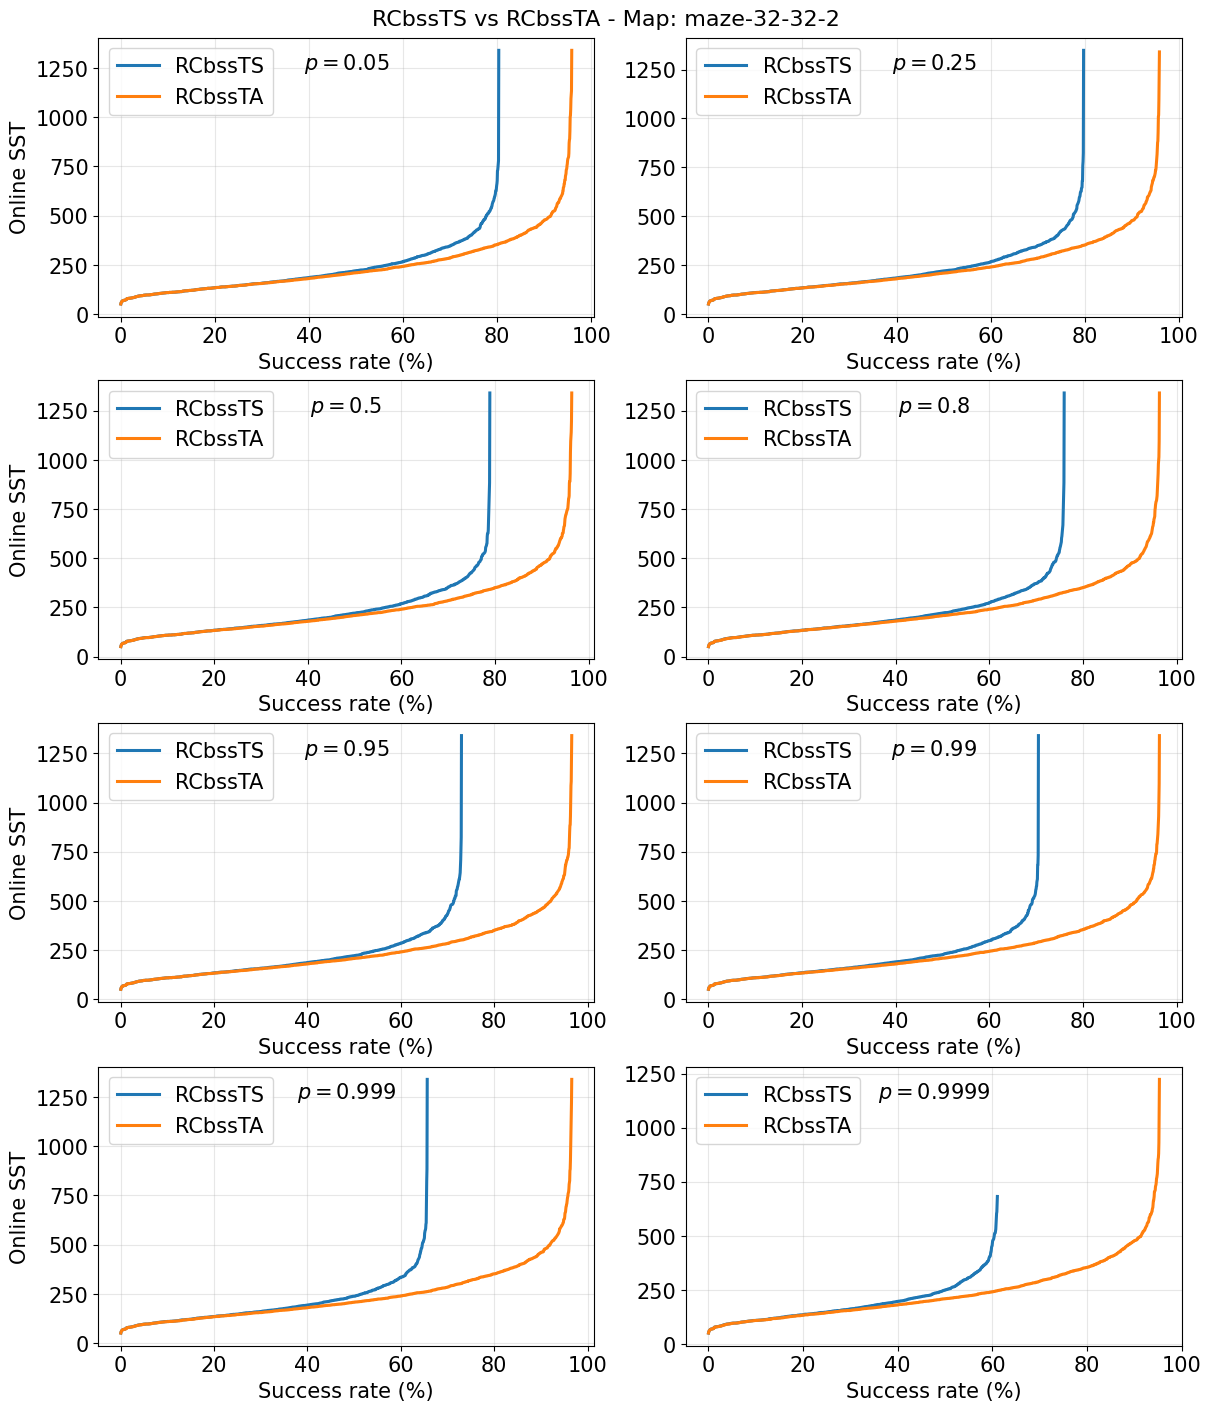

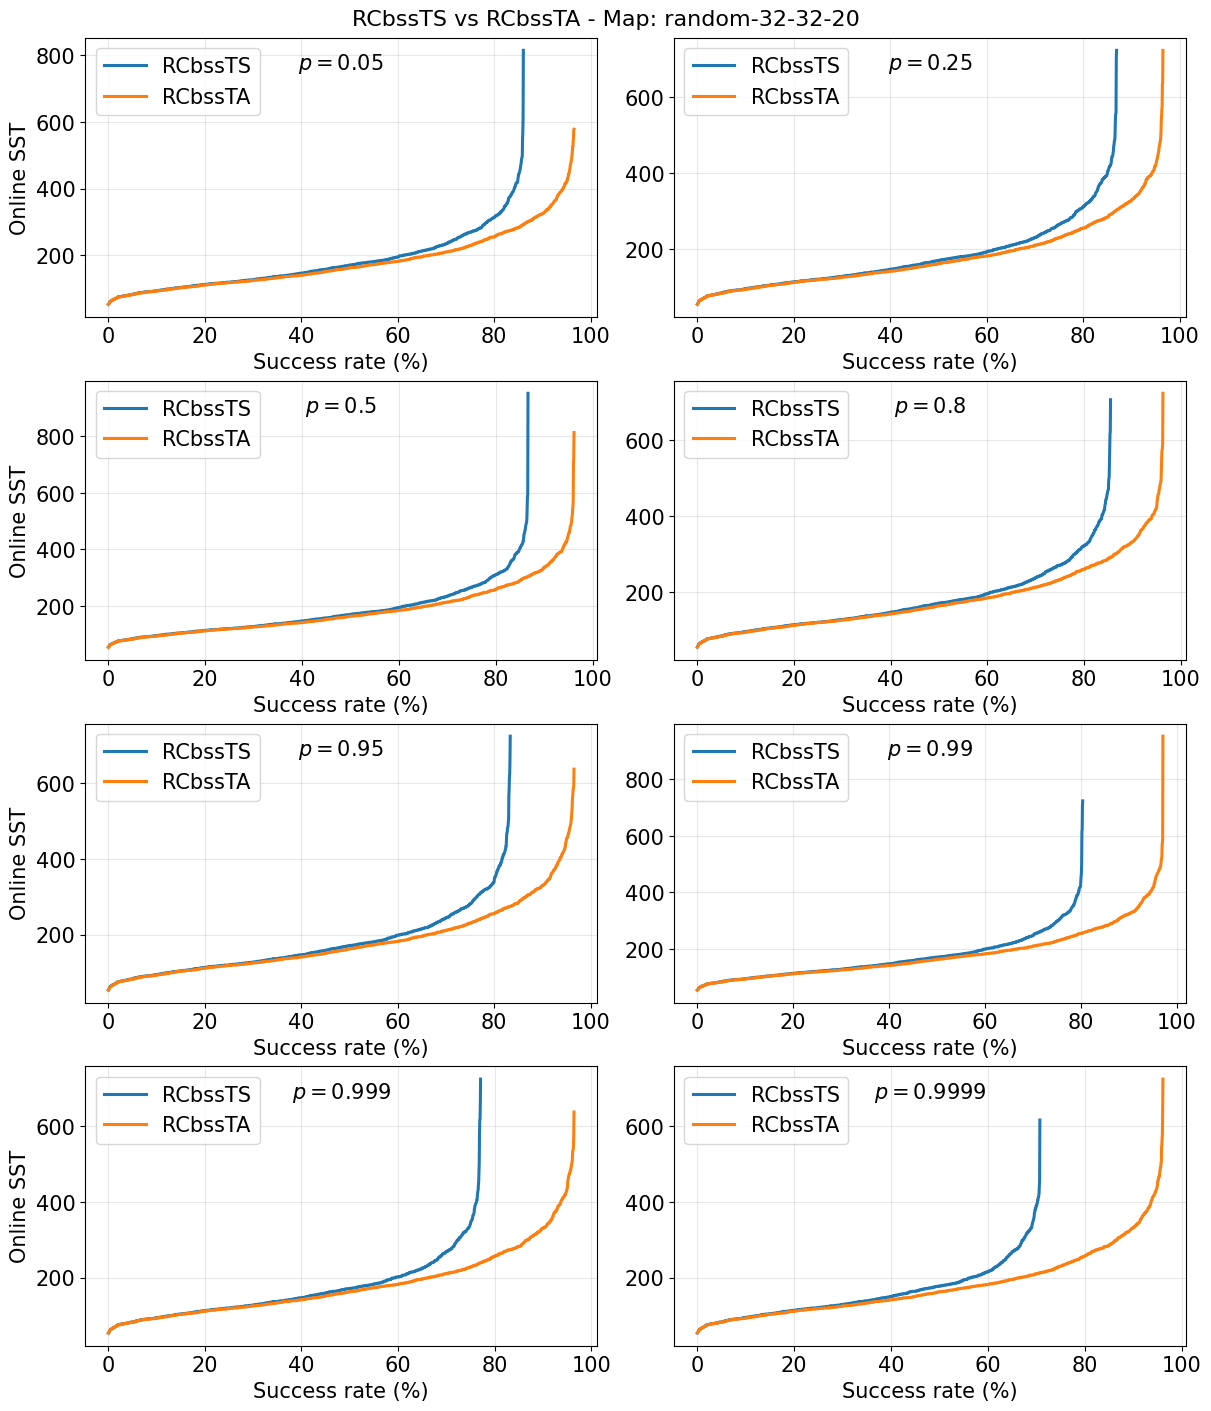

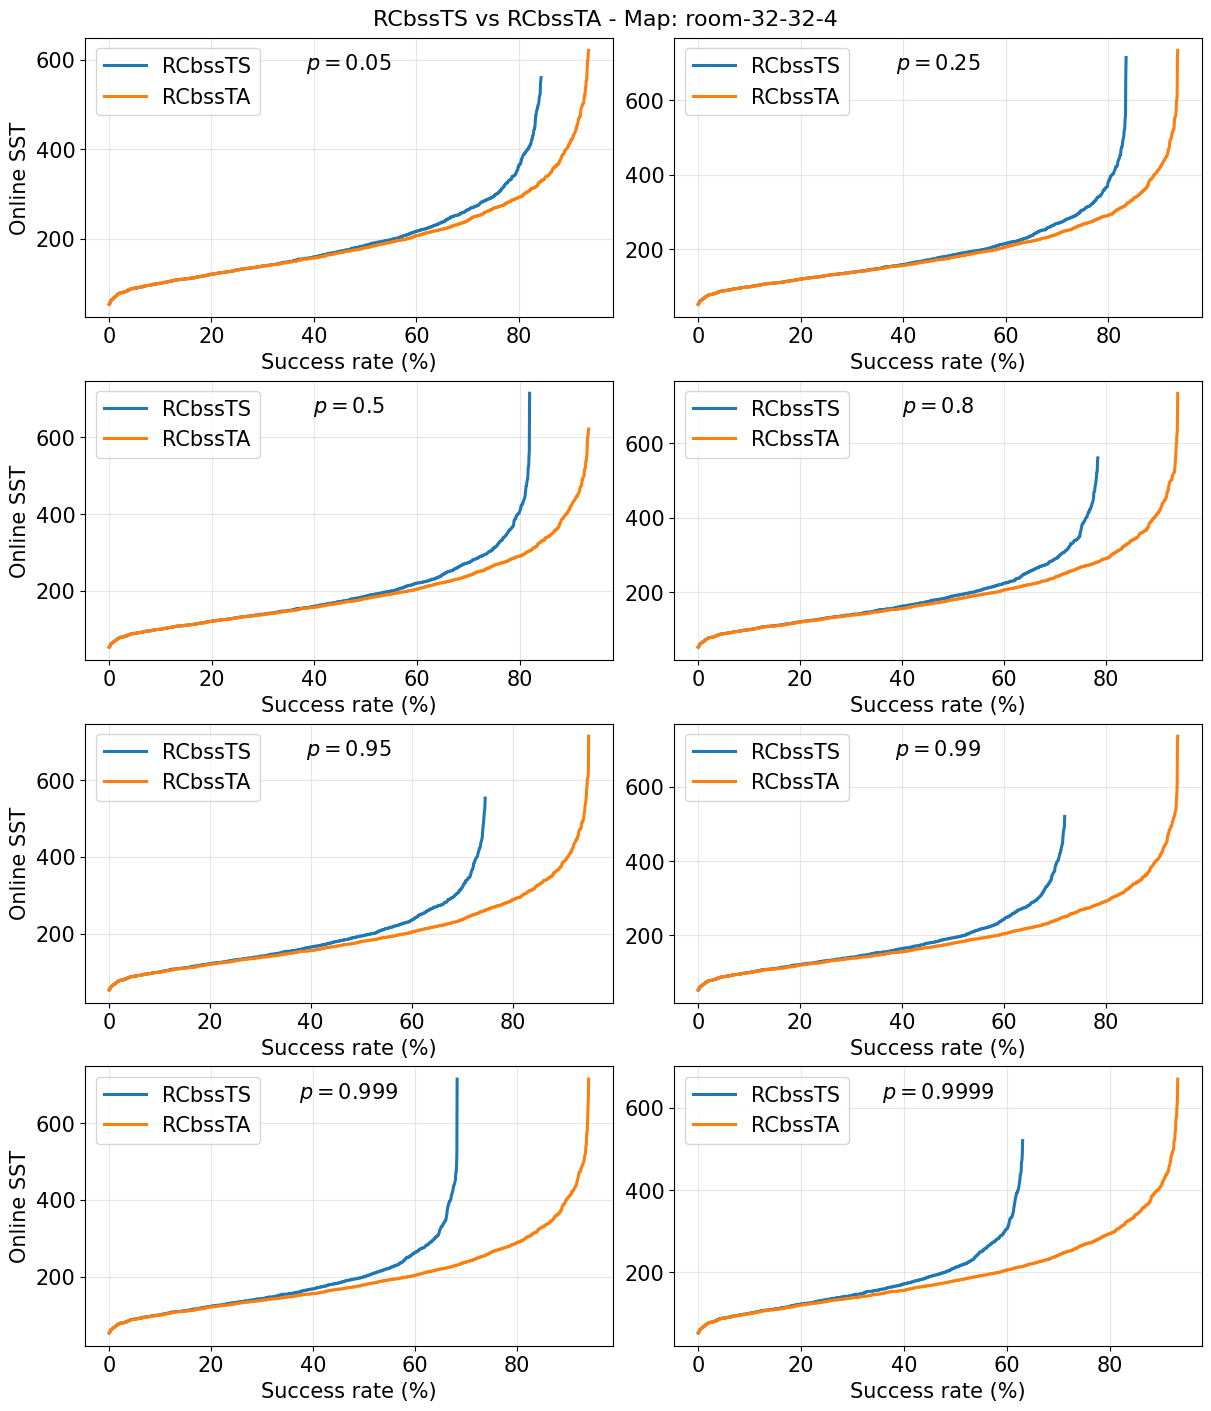

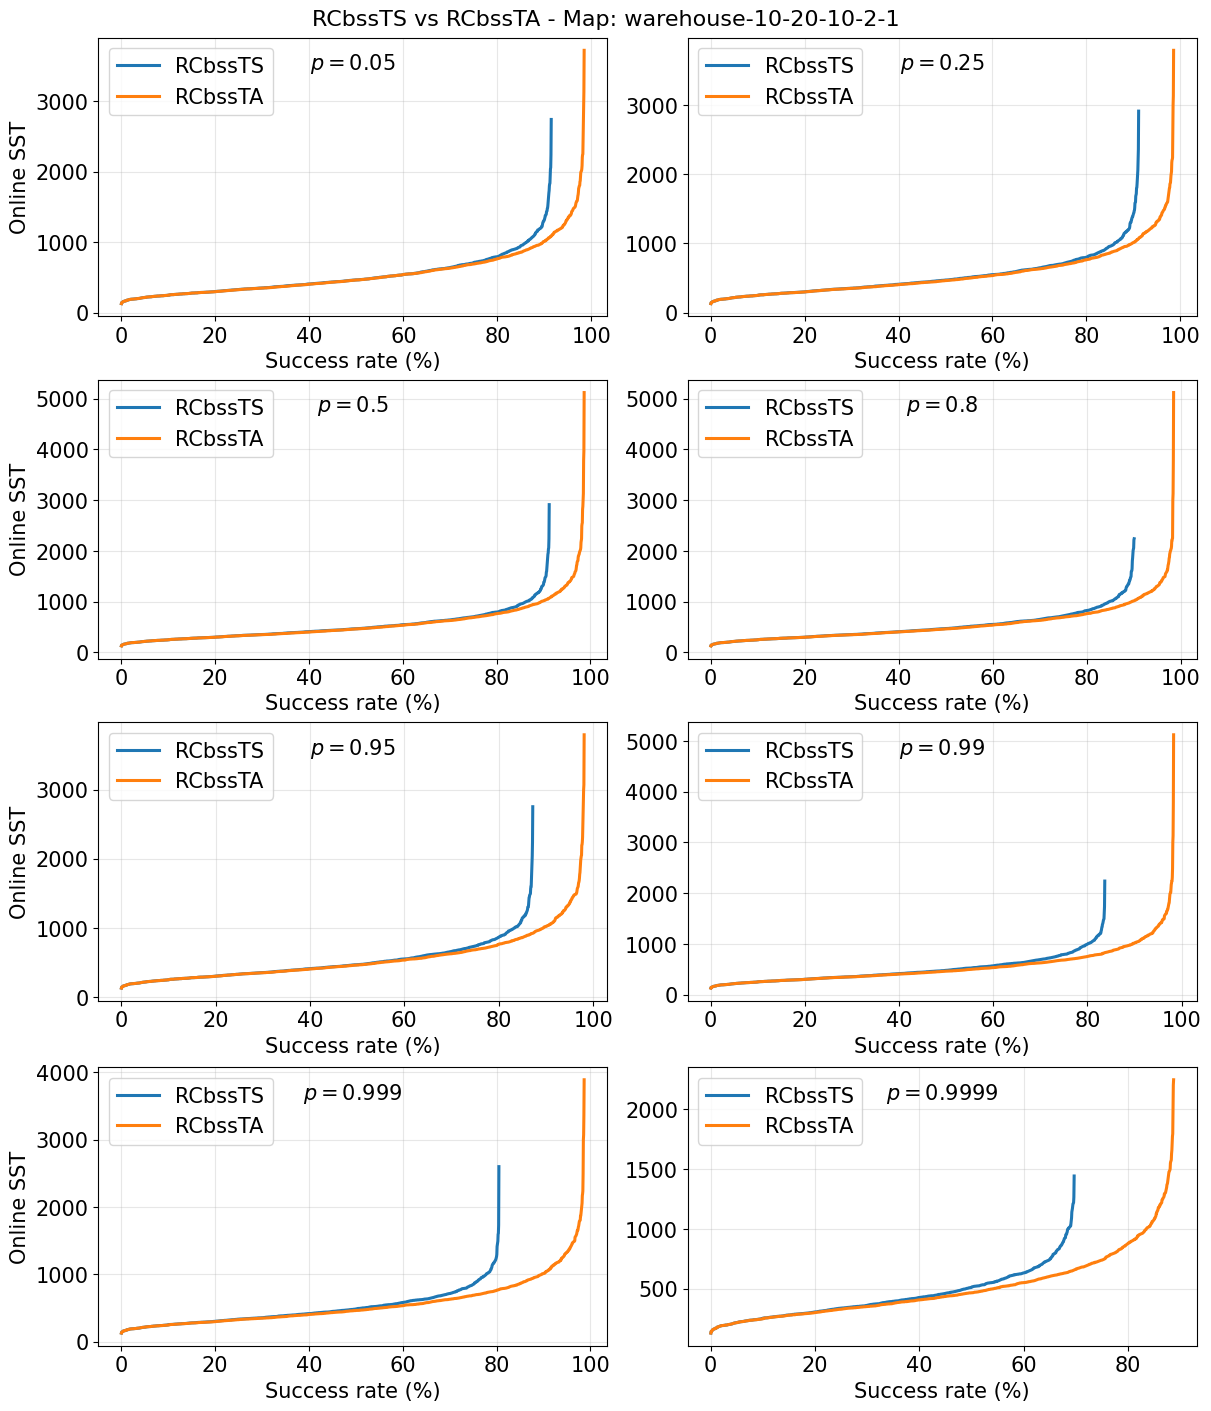

In [12]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Configuration
# =========================
INPUT_CSV = "/content/raw_data.csv"

COL_MAP = "Map"
COL_ALG = "Algorithm"
COL_P   = "Desired Safe prob"
COL_RT  = "Runtime"
COL_SST = "Online Sum of Service Time"

STRICT_ALG = "RCbssTS"
ANYTIME_ALG = "RCbssTA"

P_LIST = [0.05, 0.25, 0.5, 0.8, 0.95, 0.99, 0.999, 0.9999]

# =========================
# Font sizes
# =========================
TITLE_FS = 15
LABEL_FS = 15
TICK_FS  = 15
LEGEND_FS = 15
LINE_WIDTH = 2.2
SUPTITLE_FS = 16

# =========================
# Helpers
# =========================
def is_valid_runtime(x) -> bool:
    if pd.isna(x):
        return False
    s = str(x).strip()
    return s != "" and s.upper() != "NONE"

def to_float_p(x):
    try:
        return float(str(x).strip())
    except Exception:
        return None

def p_equal(a, b, tol=1e-12) -> bool:
    if a is None or b is None:
        return False
    return math.isclose(a, b, rel_tol=tol, abs_tol=tol)

def build_curve(df_cfg: pd.DataFrame):
    """
    ys = sorted SST of solved instances
    xs = 100 * k / N_total (all instances, including failures)
    """
    N_total = len(df_cfg)
    if N_total == 0:
        return [], []

    df_cfg = df_cfg.copy()
    df_cfg["_valid_runtime"] = df_cfg[COL_RT].apply(is_valid_runtime)
    df_cfg["_sst"] = pd.to_numeric(df_cfg[COL_SST], errors="coerce")

    solved = df_cfg[df_cfg["_valid_runtime"] & df_cfg["_sst"].notna()]["_sst"] \
        .sort_values().to_numpy()

    if len(solved) == 0:
        return [], []

    ys = solved
    xs = [100.0 * (i + 1) / N_total for i in range(len(ys))]
    return xs, ys

# =========================
# Load + normalize
# =========================
df = pd.read_csv(INPUT_CSV)
df["_p_num"] = df[COL_P].apply(to_float_p)

# =========================
# Plot per map
# =========================
nrows, ncols = 4, 2

for map_name, df_map in df.groupby(COL_MAP):
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(12, 14),
        constrained_layout=True
    )
    axes = axes.flatten()

    for idx, (ax, p) in enumerate(zip(axes, P_LIST)):
        # Strict
        df_strict = df_map[
            (df_map[COL_ALG].astype(str).str.strip() == STRICT_ALG) &
            (df_map["_p_num"].apply(lambda x: p_equal(x, p)))
        ]
        xs_s, ys_s = build_curve(df_strict)
        if xs_s:
            ax.plot(xs_s, ys_s, linewidth=LINE_WIDTH, label=STRICT_ALG)

        # Anytime
        df_any = df_map[
            (df_map[COL_ALG].astype(str).str.strip() == ANYTIME_ALG) &
            (df_map["_p_num"].apply(lambda x: p_equal(x, p)))
        ]
        xs_a, ys_a = build_curve(df_any)
        if xs_a:
            ax.plot(xs_a, ys_a, linewidth=LINE_WIDTH, label=ANYTIME_ALG)

        ax.text(
            0.5, 0.95,
            rf"$p = {p}$",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=TITLE_FS,
            fontweight="bold"
        )

        ax.set_xlabel("Success rate (%)", fontsize=LABEL_FS)
        if idx % ncols == 0:
            ax.set_ylabel("Online SST", fontsize=LABEL_FS)

        ax.tick_params(axis="both", labelsize=TICK_FS)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=LEGEND_FS)

    fig.suptitle(
        f"{STRICT_ALG} vs {ANYTIME_ALG} - Map: {map_name}",
        fontsize=SUPTITLE_FS
    )

    plt.show()
